In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import numpy as np
import torch

from src import get_device, read_dicom, Detector, Siddon

In [2]:
# Read in the volume
volume, spacing = read_dicom("../data/cxr")

# Get parameters for the detector
bx, by, bz = np.array(volume.shape) * np.array(spacing) / 2
detector_kwargs = {
    "sdr"   : 300.0,
    "theta" : torch.pi,
    "phi"   : 0,
    "gamma" : torch.pi / 3,
    "bx"    : bx,
    "by"    : by,
    "bz"    : bz,
}

device = get_device("cuda")

In [3]:
def plot_volume(volume, spacing, ax):
    
    # Get the dimensions of the volume
    Nx, Ny, Nz = np.array(volume.shape) * np.array(spacing)
    X, Y, Z = np.meshgrid(
        np.arange(0, Nx, spacing[0]) + bx, 
        np.arange(0, Ny, spacing[1]) + by, 
       -np.arange(0, Nz, spacing[2]) + bz
    )
    
    kw = {
        'vmin': volume.min(),
        'vmax': volume.max(),
        'levels': np.linspace(volume.min(), volume.max(), 10),
        'cmap': 'gray'
    }
    
    # Plot contour surfaces
    idx = 256
    _ = ax.contourf(
        X[:, :, 0], Y[:, :, 0], volume[:, :, 0],
        zdir='z', offset=Z.max(), **kw
    )
    _ = ax.contourf(
        X[idx, :, :], volume[idx, :, :], Z[idx, :, :],
        zdir='y', offset=Y.min(), **kw
    )
    _ = ax.contourf(
        volume[:, idx, :], Y[:, idx, :], Z[:, idx, :],
        zdir='x', offset=X.max(), **kw
    )
    
    # Set limits of the plot from coord limits
    cushion = 350
    xmin, xmax = X.min(), X.max()
    ymin, ymax = Y.min(), Y.max()
    zmin, zmax = Z.min(), Z.max()
    ax.set(xlim=[xmin-cushion, xmax+cushion], ylim=[ymin-cushion, ymax+cushion], zlim=[zmin-cushion, zmax+cushion])
    
    return ax


def plot_camera(source, rays, ax):
    
    # Plot the source
    source = source.detach().cpu().numpy()
    ax.scatter3D(source[0], source[1], source[2])
    
    # Plot the detector plane
    v0 = rays[0, 0, :].detach().cpu().numpy()
    v1 = rays[-1, 0, :].detach().cpu().numpy()
    v2 = rays[0, -1, :].detach().cpu().numpy()
    v3 = rays[-1, -1, :].detach().cpu().numpy()
    pts = np.array([v0, v1, v2, v3])
    ax.scatter3D(pts[:, 0], pts[:, 1], pts[:, 2])
    verts = [[pts[0], pts[1], pts[3], pts[2]]]
    ax.add_collection3d(Poly3DCollection(verts, facecolors='cyan', linewidths=1, edgecolors='r', alpha=0.2))
    
    # Plot the rays
    for i in range(0, 201, 200):
        for j in range(0, 201, 200):
            pt = rays[i, j, :].detach().cpu()
            ax.plot3D([pt[0], source[0]], [pt[1], source[1]], [pt[2], source[2]], "k--", alpha=0.75)
            
    return ax

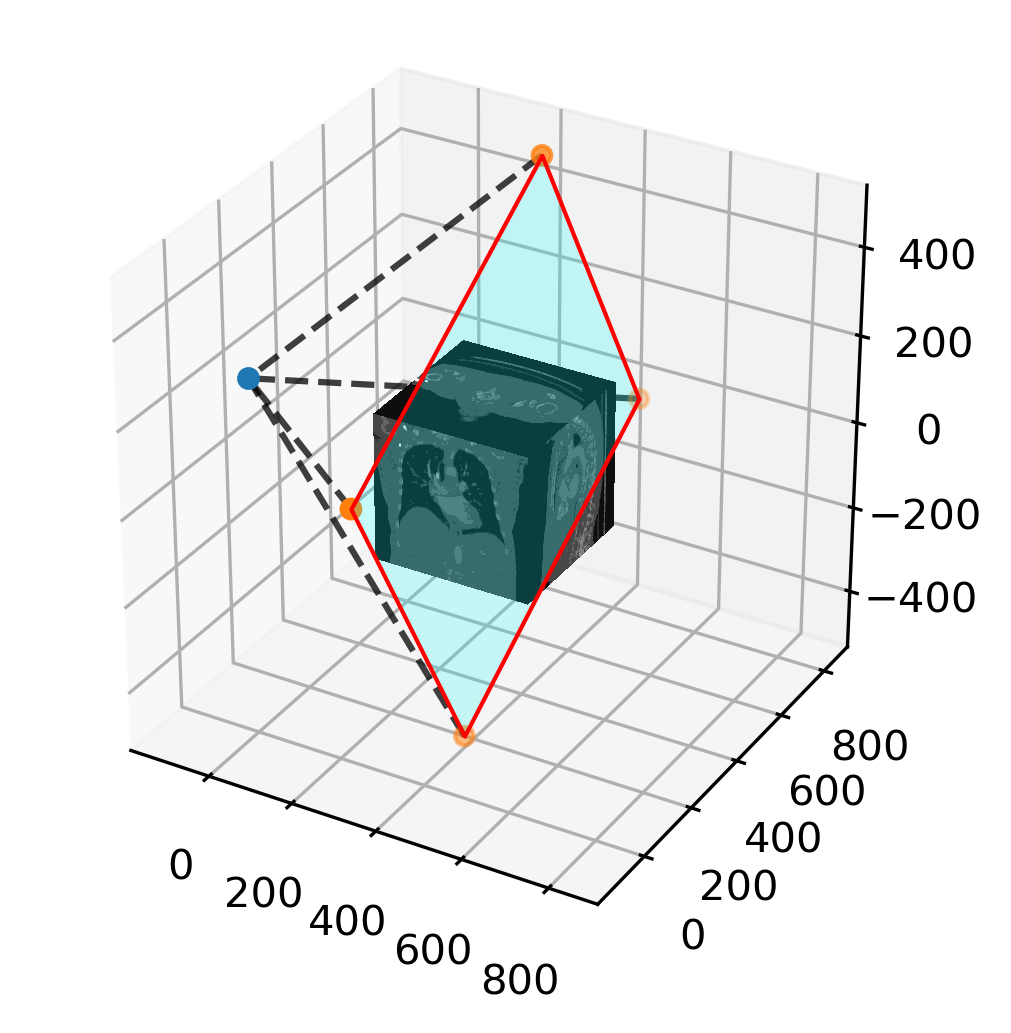

In [4]:
# Create a figure with 3D ax
fig = plt.figure(figsize=(5, 4), dpi=300)
ax = fig.add_subplot(111, projection='3d')

# Plot contour surfaces
ax = plot_volume(volume, spacing, ax)

# Plot the camera
detector = Detector(device=device, **detector_kwargs)
source, rays = detector.make_xrays(201, 201, 1.4e-2, 1.4e-2)
ax = plot_camera(source, rays, ax)

ax.set_box_aspect((1, 1, 1))
plt.show()